## Random Tree vs. Random Forest

Random Tree takes seconds vs. Random Forest minutes in processing time.  Better to start with trees and move to the forest with less data. Unless you have a lot of TV to watch in the mean time.

In [47]:
import pandas as pd
import numpy as np

# matplotlib and sns plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# run time
import time

# Decision Tree
from sklearn import tree

# A convenience for displaying decision tree visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Random Forests

Data from Lending Club to predict the state of a loan given some information about it.  The fastest runtime is the simplest random forest - after cleaning dataset, and creating categorical variables of string based variables.

Dataset [here](https://www.lendingclub.com/info/download-data.action)

2015 data.  [Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0)

In [13]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Warning about dtypes.

/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## Check Data Type

In [15]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3



## Data Cleaning

Drop variables that have the most unique types within them (especially if they're not relevant to the analysis) - for example: emp_titl, url, earliest_cr_line, revol_util.

In [16]:
# Drop columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [17]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')


In [18]:
# Drop rows with all entries as 'NAN'
y2015 = y2015.dropna(how='all')

# Drop column member ID since ID should be sufficient
y2015 = y2015.drop(columns=['member_id'])

In [19]:
# Look at the end of the file.
y2015.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421090,36371250.0,10000.0,10000.0,10000.0,36 months,11.99,332.10,B,8 years,RENT,...,0.0,1.0,100.0,100.0,0.0,0.0,32950.0,25274.0,9200.0,15850.0
421091,36441262.0,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,10+ years,MORTGAGE,...,0.0,2.0,56.5,100.0,0.0,0.0,152650.0,8621.0,9000.0,0.0
421092,36271333.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,RENT,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0


In [20]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

## Run Random Forest Ensemble Model

y = loan_status is dependent variable
x = drop loan_status from indendent variables


Results:
- Accuracy of the cross validation scores for the tree is at about 98% accuracy.

Problems:
- No feature selection or model refinement, so a lot of unneeded features
- Inconsistencies in the accuracy scores. One score is 93% while others resulted in higher than 98%

In [130]:
%%timeit

# Random Forest Ensemble model
rfc = ensemble.RandomForestClassifier()

# Drop loan_status from data
X_rfc = y2015.drop('loan_status', 1)

# Set dependent variable y as loan_status
Y_rfc = y2015['loan_status']

# Create categoical variables out of non-numerical columns with get_dummies
X_rfc = pd.get_dummies(X_rfc)

# Drop all NaN 
X_rfc = X_rfc.dropna(axis=1)

# Get cross validation scores for Random Forest
print(cross_val_score(rfc, X_rfc, Y_rfc, cv=10))


[0.98031393 0.98081261 0.9816675  0.98166706 0.97292805 0.97926858
 0.97200123 0.98071625 0.98012207 0.98092908]
[0.98059889 0.98081261 0.98154876 0.98188079 0.97494657 0.97563524
 0.96691919 0.9807875  0.97995583 0.98104783]
[0.98086011 0.97998148 0.98178623 0.9817858  0.96910473 0.9777725
 0.9617184  0.9806925  0.98043081 0.98064409]
[0.98040892 0.98057515 0.98112132 0.98190454 0.96839231 0.97508905
 0.96100596 0.98097749 0.97990833 0.98045409]
[0.98064639 0.97998148 0.98183373 0.98171456 0.96627879 0.97639516
 0.96190838 0.9807875  0.98005082 0.98054909]
[0.98074137 0.98026644 0.98173874 0.9817858  0.97098076 0.9777725
 0.96361823 0.9807875  0.97943335 0.98047784]
[0.97962528 0.98067013 0.98169124 0.98164332 0.97727381 0.97513655
 0.97055261 0.98074    0.97981333 0.98014535]
[0.97998148 0.979839   0.98138254 0.98154833 0.97827119 0.97903111
 0.96231209 0.98064501 0.98007457 0.98062034]
4min 54s ± 19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## DRILL: Third Attempt

- Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

- First, dive into the data that we have and see which features are most important: raw features or generated dummies. 
- Think about using PCA or correlation matrices.

- Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [24]:
# Get categories of loan_status
y2015['loan_status'].value_counts()


Current               287413
Fully Paid             87989
Charged Off            29177
Late (31-120 days)      9510
In Grace Period         4320
Late (16-30 days)       1888
Default                  796
Name: loan_status, dtype: int64

In [25]:
# There may be an issue with datatypes

# Get columns sorted by datatype
g_1 = y2015.columns.to_series().groupby(y2015.dtypes).groups
g_1

{dtype('float64'): Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
        'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
        'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
        'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv',
        'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
        'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
        'last_pymnt_amnt', 'collections_12_mths_ex_med',
        'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint',
        'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
        'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
        'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
        'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
        'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
        'bc_open_to_buy', 'bc_util', 'c

- Will drop pymnt_plan since all entries are 'n'
- Will drop verification_status_joint since entries are related to application_type JOINT only (and application_type feature will cover it - colinearity?)


In [26]:
# payment plan column appears useless
y2015.loc[y2015['pymnt_plan'] != 'n']

# Drop pymnt_plan and verification_status_joint from y2015
y2015 = y2015.drop(columns=['pymnt_plan', 'verification_status_joint'])

In [27]:
y2015_string = y2015[['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
                     'issue_d', 'loan_status', 'purpose', 'title', 'initial_list_status',
                     'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type'
                     ]]

y2015_string.head()

,term,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,60 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL
1,36 months,A,8 years,MORTGAGE,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL
2,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,w,Sep-2016,NaN,Jan-2017,INDIVIDUAL
3,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,Current,debt_consolidation,Debt consolidation,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL
4,36 months,E,8 years,RENT,Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,w,May-2016,NaN,Jun-2016,INDIVIDUAL


## Run Random Forest again get_dummies of all string features (continuous features removed)

- on get_dummies of y2015_string achieve consistent scores still above 90%
- could just stop here since this rfc_2 ensemble random forest meets criteria of challenge
- since these categorical variable only represent part of data, will run pca on continuous variables to explore potential reduction in combinations of continuous and categorical data
- PCA works best with continuous variables.  On categorical variables, PCA = non-zero matrix factorization

In [129]:
%%timeit

# Drop loan status and run get_dummies on y2015_string

rfc_2 = ensemble.RandomForestClassifier()

X_rfc_2 = y2015_string.drop('loan_status', 1)
Y_rfc_2 = y2015_string['loan_status']

X_rfc_2 = pd.get_dummies(X_rfc_2)
X_rfc_2 = X_rfc_2.dropna(axis=1)

print(cross_val_score(rfc_2, X_rfc_2, Y_rfc_2, cv=10))


[0.92932963 0.92127948 0.91940348 0.92189504 0.88831631 0.91052007
 0.89755159 0.92723473 0.91742466 0.92974873]
[0.93111064 0.91251692 0.91857234 0.92415103 0.89211589 0.91194491
 0.89360944 0.92773345 0.92754174 0.92659003]
[0.93194177 0.91714754 0.91315808 0.92391356 0.89743529 0.91033009
 0.89460685 0.92654602 0.92250695 0.93240868]
[0.93004203 0.91933224 0.91807366 0.91947281 0.88684398 0.91201615
 0.89455936 0.92797093 0.91450353 0.93233743]
[0.92638503 0.91467788 0.9207333  0.92089765 0.88553788 0.91021135
 0.88712627 0.92485988 0.9260693  0.89172564]
[0.92875971 0.91470162 0.9163164  0.92334362 0.8986939  0.90650677
 0.90458097 0.92785219 0.92402688 0.92317009]
[0.93042198 0.9166726  0.91921351 0.92066018 0.90289717 0.91446212
 0.9030611  0.92573858 0.90837628 0.91640146]
[0.9309919  0.91705255 0.91999715 0.92350986 0.89750653 0.90776538
 0.90260989 0.92754346 0.9200608  0.91697145]
2min 14s ± 3.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## PCA on continuous features

In [83]:
# PCA: reduce dimensionality and prevent multi-colinearity - this will help to
# identify the right variables to use (can't include categorical variables - axis=1 because it's a city

# Set the variable with all continuous variables
y2015_numerical = y2015.drop(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
                     'issue_d', 'purpose', 'title', 'initial_list_status',
                     'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type'
                     ], axis=1)

y2015_numerical.head()


,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,Current,33.18,0.0,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,Current,22.44,0.0,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,Fully Paid,26.02,0.0,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,Current,21.60,0.0,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,Fully Paid,25.49,0.0,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [30]:
# PCA with numerical features

# Remove dependent variable from x (independent variables)
y2015_numerical_x = y2015_numerical.drop('loan_status', 1)

# Drop NaN
y2015_numerical_x = y2015_numerical_x.dropna(axis=1)

# Normalize data
X_numerical = StandardScaler().fit_transform(y2015_numerical_x)

# Instantiate the PCA model
model_pca_numerical = PCA(n_components=5)

# Fit the model
Y_sklearn_numerical = model_pca_numerical.fit_transform(X_numerical)

# Values below are principal component values - they describe how important each axis is

# These axes are eigenvectors
# Eigenvector - is unit in x direction, is unit in y direction, is unit in z direction

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    model_pca_numerical.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [0.18225247 0.1069335  0.0622729  0.06010578 0.05458631]


In [31]:
Y_sklearn_numerical[:, 0]

array([ 3.61091561, -3.36310733,  2.41101301, ..., -2.66347418,
        0.58500053, -2.18821933])

## Get types and shapes to adjust to fit PCA components on continuous data back to categorical data to re-run Random Forest

In [32]:
# shape gets reduced from 57 to 5:
# Now we have 5 random PCA variables, but only need first two components

print('Shape of data before PCA: ', X_numerical.shape)
print('Shape of data after  PCA: ', Y_sklearn_numerical.shape)

print('Shape of Categorical Data where PCA components will be added: ', y2015_string.shape)

Shape of data before PCA:  (421093, 57)
Shape of data after  PCA:  (421093, 5)
Shape of Categorical Data where PCA components will be added:  (421093, 14)


In [33]:
# Get types
# Type of PCA components
print('Type of PCA Components: ', type(Y_sklearn_numerical))
print('Type of Categorical Variables: ',type(y2015_string))

Type of PCA Components:  <class 'numpy.ndarray'>
Type of Categorical Variables:  <class 'pandas.core.frame.DataFrame'>


In [34]:
# Make sure length matches row numbers
len(Y_sklearn_numerical[:,0])

421093

In [35]:
# create new variable that connects continuous components and catgorical data
# use .copy to avoid copy warning - but adds strain to memory - better way?
categorical_pca_combined = y2015_string.copy()

In [36]:
# First PCA Component
categorical_pca_combined['pca_1'] = Y_sklearn_numerical[:,0]

In [37]:
categorical_pca_combined.head()

,term,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,pca_1
0,60 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL,3.610916
1,36 months,A,8 years,MORTGAGE,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL,-3.363107
2,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,w,Sep-2016,NaN,Jan-2017,INDIVIDUAL,2.411013
3,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,Current,debt_consolidation,Debt consolidation,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL,4.230372
4,36 months,E,8 years,RENT,Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,w,May-2016,NaN,Jun-2016,INDIVIDUAL,-0.140161


In [128]:
%%timeit

# Cross Validation of Random Tree with Categorical Variables and PCA component 1
# Drop loan status and run get_dummies on y2015_string with added continuous variables from PCA components 1

rfc_3 = ensemble.RandomForestClassifier()

X_rfc_3 = categorical_pca_combined.drop('loan_status', 1)
Y_rfc_3 = categorical_pca_combined['loan_status']

X_rfc_3 = pd.get_dummies(X_rfc_3, drop_first=True)
X_rfc_3 = X_rfc_3.dropna(axis=1)

print(cross_val_score(rfc_3, X_rfc_3, Y_rfc_3, cv=10))


[0.89800765 0.85106029 0.85412363 0.86143434 0.81621943 0.8506293
 0.77933458 0.8923245  0.71957157 0.53861682]
[0.89663033 0.85459856 0.85540595 0.85924958 0.82011399 0.85516504
 0.80087392 0.89296571 0.74526801 0.53180069]
[0.89717651 0.85806559 0.86217378 0.85803847 0.81526953 0.85176918
 0.79049609 0.89272822 0.70850452 0.528832  ]
[0.89670157 0.85279381 0.85735319 0.86027072 0.81177867 0.84998813
 0.76456339 0.89051962 0.72600755 0.51617347]
[0.89617915 0.85635582 0.85968037 0.85941582 0.81783424 0.84920446
 0.79078107 0.89104208 0.69256893 0.56155892]
[0.89765144 0.85063285 0.85811308 0.86015198 0.82111137 0.85103301
 0.76750813 0.89142206 0.72415513 0.56588135]
[0.89933747 0.85265133 0.85659329 0.85856091 0.81021135 0.8484683
 0.77164027 0.89180203 0.72909492 0.57260248]
[0.8969153  0.8531975  0.86036902 0.86143434 0.81327476 0.85238661
 0.79082856 0.88892847 0.73507968 0.47964661]
2min 24s ± 3.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
# Cross Validation of Random Tree with Categorical Variables and PCA component 1 and 2
#Add in component #2

# : = all rows; slicing 2nd component from pca component
# taking datatype = ndarray and adding new column (independent variable) to df
categorical_pca_combined['pca_2'] = Y_sklearn_numerical[:,1]

In [127]:
%%timeit
# Drop loan status and run get_dummies on y2015_string with added continuous variables from PCA components 1 and 2

rfc_4 = ensemble.RandomForestClassifier()

X_rfc_4 = categorical_pca_combined.drop('loan_status', 1)
Y_rfc_4 = categorical_pca_combined['loan_status']

X_rfc_4 = pd.get_dummies(X_rfc_4, drop_first=True)
X_rfc_4 = X_rfc_4.dropna(axis=1)

print(cross_val_score(rfc_4, X_rfc_4, Y_rfc_4, cv=10))


[0.89532426 0.84887559 0.86053525 0.85953455 0.81230112 0.85473759
 0.78819255 0.89144581 0.75201273 0.52453332]
[0.89587044 0.85374368 0.8620313  0.85981952 0.81427214 0.85723106
 0.7650146  0.89108958 0.70886076 0.51581722]
[0.90023984 0.8487806  0.85998908 0.85837093 0.81930658 0.85231536
 0.79344083 0.89044837 0.72372765 0.58043984]
[0.89684405 0.85110779 0.858683   0.85799098 0.81783424 0.85200665
 0.80092142 0.89213451 0.71748165 0.52363084]
[0.89743772 0.85032414 0.85718696 0.86274044 0.81975778 0.85214913
 0.76297229 0.89249074 0.7126606  0.52507956]
[0.89736648 0.85352996 0.86143763 0.85889337 0.81287105 0.85160294
 0.79132727 0.89282322 0.72873869 0.54106303]
[0.89608416 0.85001544 0.85732944 0.85782474 0.82123011 0.84979815
 0.79776295 0.89094709 0.70104733 0.59468959]
[0.89658284 0.85647456 0.85770939 0.85772976 0.80878651 0.85404892
 0.80581348 0.89127957 0.74467428 0.55298532]
2min 28s ± 12.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Identify which columns make up identified components

In [ ]:
# Numerical data plotted to find the features in the component that are
data_to_plot_numerical = y2015_numerical.drop(['loan_status'], axis=1)
data_to_plot_numerical['Component'] = Y_sklearn_numerical[:,0]
data_to_plot_numerical = pd.melt(data_to_plot_numerical, id_vars='Component')

g_numerical = sns.FacetGrid(data_to_plot_numerical, col="variable", col_wrap=2, height=7.5, aspect=1)
g_numerical = g_numerical.map(
  sns.regplot,
  "Component",
  "value",
  x_jitter=.49,
  y_jitter=.49,
  fit_reg=False
)

plt.show()

## The numerical features that appear to have the most variance responsible for the outcome
- total_il_high_credit_limit
- tot_hi_cred_lim
- total_rev_hi_lim
- tot_cur_bal
- revol_bal
- annual_inc
- total_il_high_credit_limit
- total_rev_hi_lim

### Scores are lower, but more consistent

In [126]:
%%timeit

# Rerun ensemble model with numerical features identified by PCA

y2015_numerical_features = y2015[['total_il_high_credit_limit', 'tot_hi_cred_lim', 'total_rev_hi_lim',
                                  'tot_cur_bal', 'revol_bal', 'annual_inc', 'total_il_high_credit_limit',
                                  'total_rev_hi_lim' 
                     ]]

# Drop loan status from x
rfc_numerical_features = ensemble.RandomForestClassifier()
X_rfc_numerical_features = y2015_numerical_features
Y_rfc_numerical_features = y2015['loan_status']
X_rfc_numerical_features = pd.get_dummies(X_rfc_numerical_features)
X_rfc_numerical_features = X_rfc_numerical_features.dropna(axis=1)

print(cross_val_score(rfc_numerical_features, X_rfc_numerical_features, Y_rfc_numerical_features, cv=10))


[0.64921279 0.65042388 0.64790672 0.64896699 0.65165044 0.64956067
 0.65043102 0.64887907 0.65162562 0.65282858]
--- %s seconds --- 57452.912559747696
[0.64871411 0.64667189 0.64747928 0.64865828 0.65103301 0.64944194
 0.65133344 0.64868909 0.65031942 0.6514036 ]
--- %s seconds --- 57644.13221979141
[0.64759801 0.64823918 0.65021016 0.64818333 0.64896699 0.6506768
 0.64919613 0.65051772 0.65207685 0.65021612]
--- %s seconds --- 57841.575177907944
[0.64788298 0.64686187 0.64921279 0.65001187 0.64975065 0.65043933
 0.65073975 0.64795288 0.65001069 0.64919489]
--- %s seconds --- 58049.8964779377
[0.647693   0.65132626 0.64899907 0.64777962 0.65155545 0.64830207
 0.6501223  0.6476204  0.6497257  0.65054862]
--- %s seconds --- 58258.23557496071
[0.64885659 0.64681437 0.64861913 0.64806459 0.64880076 0.6506768
 0.64632264 0.64809537 0.65229059 0.65180734]
--- %s seconds --- 58466.02596497536
[0.64802546 0.64973522 0.64755052 0.65024935 0.64894324 0.65015436
 0.64781876 0.64949653 0.65202935 

In [ ]:
# Combine PCA identified continuous variables with categorical variables
# A matrix transform that reduces dimenisionality
# PCA identifies variables that make up vector whose coordinate system is fine tuned to data: if there's variance
# in a particular random variable, identify axis that captures it so whne you get new data it's largely spread around
# a particular axis.

# PCA decomposes data into projecting it onto axes that are going to get most "action" - explain variance?
# Then we can focus on the variable that's having the greatest impact.

# Vector: can be n-dimensional (in this case 8)

# Orthogonal: No correlation between the data.  When you have more than 3 dimensions there will be corrlation.

# Projection: 

# Columns = random variables, unlike a function that produces a y given an x
# Row = sample

# Each element of the column is an observation
# From sample data, infer real statistics of random variable

# 8 random variables - we've sampled population and we get some insight on the population based on whole row:
    # total_il_high_credit_limit
    # tot_hi_cred_lim
    # total_rev_hi_lim
    # tot_cur_bal
    # revol_bal
    # annual_inc
    # total_il_high_credit_limit
    # total_rev_hi_lim

# The trick is to understand what correlation there is between samples (an entire row)
# A sample has multiple attributes, and each attribute corresponds to a random variable

# How correlated is the variance between one random variable 

# Projection is a way to decompose - shining a flash light in the number of directions you specify:
# (pca components set): PCA(n_components=5)
# Decomposing - done for each row (sample)
# (x,y) (3,2)
# Decomposing - think about what's projected onto x axis (or any axis) - in this case for x axis, 3
# Decomposing - and y (in this case) gets a 0. So, decomposed = (3,0)
    

## Decision Tree

In [110]:
y2015_decision_tree = y2015_numerical.copy()

y2015_decision_tree['default_cat'] = np.where(y2015_decision_tree['loan_status'] == 'Default', 1, 0)
y2015_decision_tree.loc[y2015_decision_tree['default_cat'] == 1]

y2015_decision_tree = y2015_decision_tree.drop(columns=['loan_status'])
y2015_decision_tree.head()


,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default_cat
0,68009401.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,0.0,...,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0,0
1,68354783.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,0.0,...,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0,0
2,68466916.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,1.0,...,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0,0
3,68466961.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,0.0,...,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0,0
4,68495092.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,4.0,...,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0,0


## For the purpose of this exercise, will remove any NaN values in order to run Decision Tree, but in the wild would want to evaluate best options for handling missing values

In [107]:
# Check for null values in columns
pd.isnull(y2015_decision_tree).sum() > 0

id                                False
loan_amnt                         False
funded_amnt                       False
funded_amnt_inv                   False
int_rate                          False
installment                       False
annual_inc                        False
dti                               False
delinq_2yrs                       False
inq_last_6mths                    False
mths_since_last_delinq             True
mths_since_last_record             True
open_acc                          False
pub_rec                           False
revol_bal                         False
total_acc                         False
out_prncp                         False
out_prncp_inv                     False
total_pymnt                       False
total_pymnt_inv                   False
total_rec_prncp                   False
total_rec_int                     False
total_rec_late_fee                False
recoveries                        False
collection_recovery_fee           False


In [116]:
# Drop rows with null values
# https://stackoverflow.com/questions/43311555/how-to-drop-column-according-to-nan-percentage-for-dataframe
y2015_decision_tree = y2015_decision_tree.dropna(how='any', axis=1)

In [117]:
# Recheck null values. Nope, not there. Those columns dropped.
pd.isnull(y2015_decision_tree).sum() > 0

id                            False
loan_amnt                     False
funded_amnt                   False
funded_amnt_inv               False
int_rate                      False
installment                   False
annual_inc                    False
dti                           False
delinq_2yrs                   False
inq_last_6mths                False
open_acc                      False
pub_rec                       False
revol_bal                     False
total_acc                     False
out_prncp                     False
out_prncp_inv                 False
total_pymnt                   False
total_pymnt_inv               False
total_rec_prncp               False
total_rec_int                 False
total_rec_late_fee            False
recoveries                    False
collection_recovery_fee       False
last_pymnt_amnt               False
collections_12_mths_ex_med    False
policy_code                   False
acc_now_delinq                False
tot_coll_amt                

## Decision Tree Time

In [120]:
%%timeit

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=3,
    max_depth=4,
)

loan_default = y2015_decision_tree['default_cat']

decision_tree.fit(y2015_decision_tree, loan_default)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names = y2015_decision_tree.columns,
    class_names=['Default', 'No Default'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

1.06 s ± 69.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Decision Tree

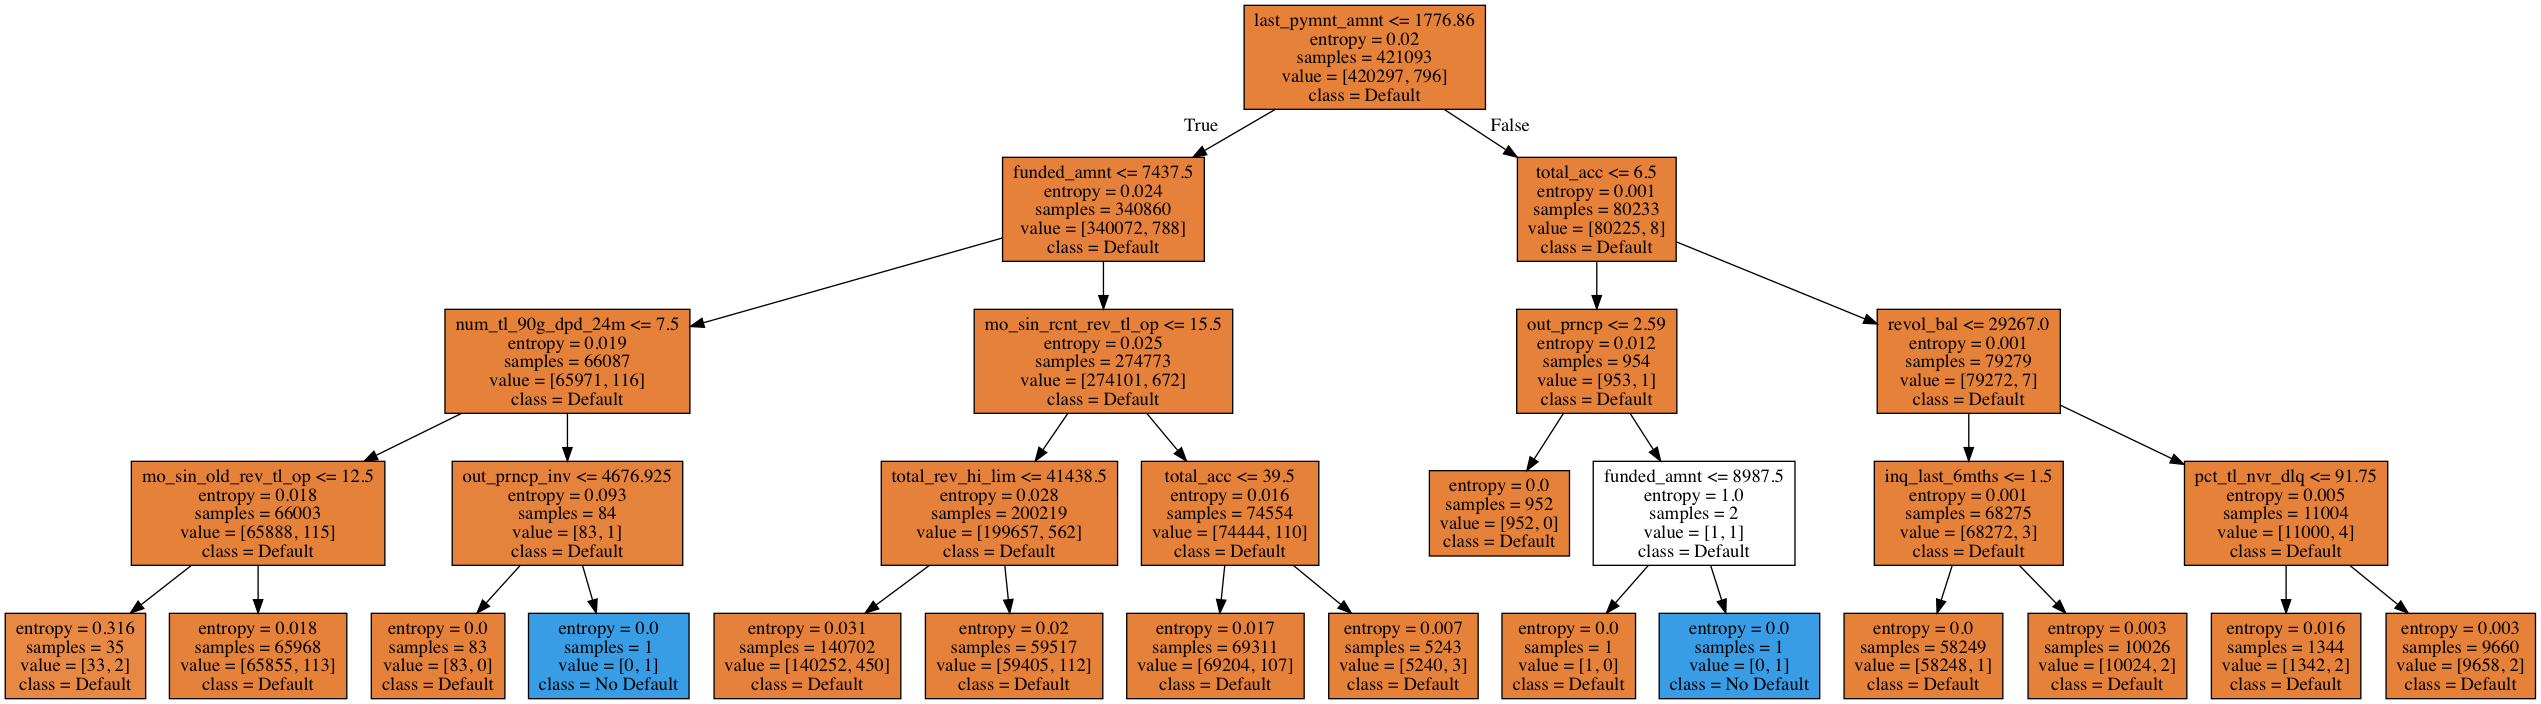

In [125]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=3,
    max_depth=4,
)

loan_default = y2015_decision_tree['default_cat']

decision_tree.fit(y2015_decision_tree, loan_default)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names = y2015_decision_tree.columns,
    class_names=['Default', 'No Default'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

## Conclusion

Doing a Random Tree is much less "expensive" in run time - it's a good place to start to explore the data to remove what can be removed prior to starting a random forest.